In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import py_scripts.db_fcns as db
import py_scripts.data_fcns as fcns
import py_scripts.plot_fcns as pf

Ei välitetä datan keruusta, vaan napataan data DB:stä.

In [2]:
alkuasema = "JÄS"
loppuasema = "OV"
# dates = pd.date_range("2023-01-01", periods=59, freq="1D")
dates = pd.date_range("2019-01-01", "2023-05-31", freq="1D")

In [3]:
#timetables = pd.DataFrame()
#for date in dates:
#    new_timetables = fcns.get_train_timetables(str(date.date()))
#    if new_timetables is None:
#        continue
#    timetables = pd.concat([timetables, new_timetables])

## Data haltuun

In [4]:
# df = db.get_df_from_db("testi", from_extra=True)
df1 = db.get_df_from_db("clean_jamsa_orivesi", from_extra=True)
# df1 = None

if df1 is None:
    df1 = db.get_df_from_db("jamsa_orivesi", from_extra=True)
    
    # poistetaan junat, joilla ei ole sijanti-/nopeustietoja korkeintaan 30 sekunnin välein
    max_time_difference = 30
    
    cleaned_df = pd.DataFrame()
    for train_num, date in df1.groupby(["trainNumber", "departureDate"]).count().index:
        t_df = fcns.get_locations_for_train(train_num, date, df1).copy()
        max_time_jump = t_df["duration"].diff(1).max()
        if max_time_jump <= max_time_difference:
            cleaned_df = pd.concat([cleaned_df, t_df])

    df1 = cleaned_df.reset_index(drop=True)
    
    distances = fcns.get_distances_from_df(df1)
    
    # poistetaan junat, joiden kulkema matka poikkeaa liikaa mediaanista
    min_dist = distances["dist_from_speed"].median() - 4 * (distances["dist_from_speed"].median() - distances["dist_from_speed"].quantile(0.02))
    max_dist = distances["dist_from_speed"].median() + 4 * (distances["dist_from_speed"].quantile(0.98) - distances["dist_from_speed"].median())
    outliers = distances[(distances["dist_from_speed"] < min_dist) | (distances["dist_from_speed"] > max_dist)].set_index(["trainNumber", "departureDate"]).index
    
    for train_num, date in outliers:
        o = fcns.get_locations_for_train(train_num, date, df1)
        i1 = o.index.min()
        i2 = o.index.max() + 1
        df1.drop(range(i1, i2), inplace=True)
    
    df1.reset_index(drop=True, inplace=True)


In [5]:
# tarviiko tallentaa?
db.save_df_to_db(df1, "clean_jamsa_orivesi", to_extra=True)

Table clean_jamsa_orivesi already exists


In [6]:
distances = fcns.get_distances_from_df(df1)
distances["duration"] = fcns.get_durations_from_df(df1).to_numpy()

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650007 entries, 0 to 650006
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   trainNumber         650007 non-null  int64              
 1   departureDate       650007 non-null  object             
 2   timestamp           650007 non-null  datetime64[ns, UTC]
 3   speed               650007 non-null  int64              
 4   duration            650007 non-null  float64            
 5   latitude            650007 non-null  float64            
 6   longitude           650007 non-null  float64            
 7   acceleration        650007 non-null  float64            
 8   change_of_location  650007 non-null  float64            
 9   dist_from_coords    650007 non-null  float64            
 10  dist_from_speed     650007 non-null  float64            
 11  stops_from_speed    650007 non-null  int64              
 12  station         

In [8]:
# df1.head()

In [9]:
# distances.head(3)

In [10]:
distances.set_index(["departureDate", "trainNumber"], inplace=True)
# distances.head(3)

In [11]:
distances.describe()

,dist_from_speed,duration
count,4192.000000,4192.000000
mean,55876.257587,2013.793177
std,118.099034,195.791049
min,54524.861111,1573.000000
25%,55851.909722,1935.000000
50%,55888.888889,1974.000000
75%,55921.145833,2034.000000
max,56537.916667,6646.000000


#### Paras arvio välin Jämsä-Orivesi pituudelle on kuljettujen matkojen mediaani (keskiarvokin kelpaisi)

In [12]:
best_dist = np.round(distances["dist_from_speed"].median(), -2)
best_dist

55900.0

In [13]:
# print(f"Havaintoja aikavälillä  {df1['timestamp'].min().date()} - {df1['timestamp'].max().date()}")

## Skaalataan etäisyydet samoiksi, lisätään checkpointit ja kiihtyvyydelle arvot checkpointeissa

In [14]:
df, checkpoints = fcns.get_essential_df(df1, best_dist)

In [15]:
# df.info()

In [16]:
# df.head()

## Keskitytään kiihtyvyyteen checkpointeissa

In [17]:
df = df[df["dist_from_speed"].isin(checkpoints)]
df.drop_duplicates(["departureDate", "trainNumber", "dist_from_speed"], inplace=True)
df.reset_index(drop=True, inplace=True)

df["acceleration+"] = df["acceleration"].apply(lambda a: max(a, 0))
df["acceleration_abs"] = df["acceleration"].apply(abs)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2347520 entries, 0 to 2347519
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   trainNumber       int64  
 1   departureDate     object 
 2   dist_from_speed   float64
 3   acceleration      float64
 4   acceleration+     float64
 5   acceleration_abs  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 107.5+ MB


### Muunnetaan dataframe klusterointiin sopivaan muotoon

In [19]:
train_df = fcns.get_cluster_df(df)
train_df.insert(0, "abs_sum", np.abs(train_df.loc[:, checkpoints]).sum(axis=1))

In [20]:
train_df.iloc[:5, :10]

,dist_from_speed,abs_sum,0.0,100.0,200.0,300.0,400.0,500.0,600.0,700.0,800.0
departureDate,trainNumber,,,,,,,,,,
2019-01-03,144,34.408792,0.000000,0.462963,0.434028,0.434028,0.434028,0.203704,0.203704,0.203704,0.052083
2019-01-11,144,22.013889,0.000000,0.388889,0.407407,0.407407,0.277778,0.277778,0.277778,0.148148,0.148148
2019-01-15,148,39.557870,-0.018519,0.351852,0.407407,0.407407,0.333333,0.333333,0.069444,0.069444,0.069444
2019-02-22,150,28.618056,0.000000,0.381944,0.370370,0.444444,0.444444,0.444444,0.129630,0.129630,0.129630
2019-02-25,144,43.266204,0.000000,0.629630,0.629630,0.190972,0.190972,0.190972,0.190972,0.055556,0.055556


In [21]:
# ongelmia?
# train_df[train_df[0.0] != 0].iloc[:, :5]

### Etsitään suurta vaihtelua (ja sitten ei tehdä löydösten perusteella mitään...)

In [22]:
descr = train_df.loc[:, checkpoints].describe().T.reset_index()
descr["75%-25%"] = descr["75%"] - descr["25%"]

In [23]:
descr.head()

,dist_from_speed,count,mean,std,min,25%,50%,75%,max,75%-25%
0,0.0,4192.0,-0.000608,0.028097,-1.685185,0.000000,0.000000,0.000000,0.000000,0.000000
1,100.0,4192.0,0.385033,0.126165,-0.138889,0.312500,0.375817,0.444444,2.259259,0.131944
2,200.0,4192.0,0.387306,0.128380,-0.814815,0.314815,0.388889,0.444444,2.259259,0.129630
3,300.0,4192.0,0.375893,0.117400,-0.296296,0.312500,0.370370,0.444444,1.197917,0.131944
4,400.0,4192.0,0.326686,0.111753,-0.314815,0.259259,0.329861,0.396825,0.981481,0.137566


In [24]:
# np.where(checkpoints == features[0])

In [25]:
# features

In [26]:
num_of_features = 20
lower_bound = descr.sort_values("75%-25%", ascending=False).iloc[num_of_features - 1, -1]
features = descr[descr["75%-25%"] >= lower_bound].index
descr.sort_values("75%-25%", ascending=False).head(num_of_features)

,dist_from_speed,count,mean,std,min,25%,50%,75%,max,75%-25%
559,55900.0,4192.0,-0.220435,0.170883,-2.037037,-0.333333,-0.185185,-0.074074,-0.013889,0.259259
558,55800.0,4192.0,-0.371033,0.161655,-2.444444,-0.462963,-0.351852,-0.259259,0.129630,0.203704
15,1500.0,4192.0,0.140110,0.127460,-0.574074,0.037037,0.114379,0.225694,1.388889,0.188657
14,1400.0,4192.0,0.152760,0.123443,-0.574074,0.055556,0.138889,0.240741,0.729167,0.185185
526,52600.0,4192.0,-0.137262,0.117735,-0.972222,-0.222222,-0.121528,-0.037037,0.520833,0.185185
557,55700.0,4192.0,-0.334835,0.148845,-2.444444,-0.425926,-0.324074,-0.240741,0.399306,0.185185
525,52500.0,4192.0,-0.137068,0.116417,-0.685185,-0.218254,-0.129630,-0.037037,0.520833,0.181217
6,600.0,4192.0,0.191585,0.114451,-1.111111,0.104167,0.203704,0.277778,0.833333,0.173611
7,700.0,4192.0,0.144001,0.107622,-0.462963,0.055556,0.129630,0.222222,0.868056,0.166667
527,52700.0,4192.0,-0.130444,0.119625,-0.833333,-0.203704,-0.111111,-0.037037,0.462963,0.166667


In [27]:
# features = checkpoints[features]
features

Int64Index([  6,   7,  13,  14,  15,  16,  21,  22,  35,  36,  37, 523, 524,
            525, 526, 527, 556, 557, 558, 559],
           dtype='int64')

## KMeans-klusterointi

Kun on siistimpää dataa, voi käyttää vähemmän klustereita.

In [28]:
rng = 4097

In [29]:
num_of_clusters = 5

km, cluster_ids = fcns.run_kmeans(train_df.loc[:, checkpoints], num_of_clusters, rng)

In [30]:
km.n_iter_

42

In [31]:
train_df.insert(0, "cluster_id", cluster_ids)

In [32]:
clustering_results = df.groupby(["departureDate", "trainNumber"]).mean()
clustering_results["cluster_id"] = km.predict(train_df.loc[:, checkpoints])
cluster_df = fcns.get_clusters(clustering_results)
cluster_df

,count,min_mean_abs_accel,max_mean_abs_accel,mean_mean_abs_accel
cluster_id,,,,
2,1274,0.040200,0.195115,0.069204
1,1235,0.048679,0.191436,0.072484
0,1212,0.018651,0.176800,0.063301
4,271,0.055220,0.176010,0.088015
3,200,0.053016,0.177085,0.084508


In [33]:
cluster_df["mean_mean_abs_accel"].sort_values() * len(checkpoints)

cluster_id
0    35.448548
2    38.754282
1    40.590904
3    47.324437
4    49.288175
Name: mean_mean_abs_accel, dtype: float64

### Ajankohdan merkitys

Tarkastellaan junavuorojen kuukausijakaumaa klustereittain. Onko jossain klusterissa paljon talvella kulkevia junia, tai kenties kesävuoroja.

In [34]:
kokeilu = clustering_results.reset_index()
kokeilu["departureDate"] = pd.to_datetime(kokeilu["departureDate"])
kokeilu.drop("dist_from_speed", axis=1, inplace=True)
kokeilu["month"] = kokeilu["departureDate"].apply(lambda t: t.month)

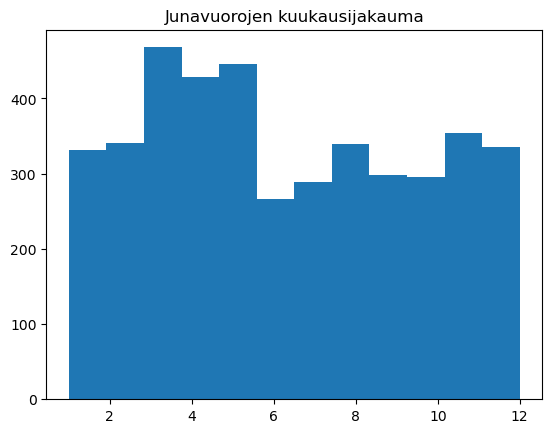

In [35]:
plt.hist(kokeilu["month"], bins=12)
plt.title("Junavuorojen kuukausijakauma")
plt.show()

Kokonaisuudessaan (datassa olevia) junavuoroja on eniten maalis-toukokuussa. Klusteri 2 näyttää painottuvan talveen, klusteri 1 kevääseen ja klusteri 0 kevääseen ja syksyyn.

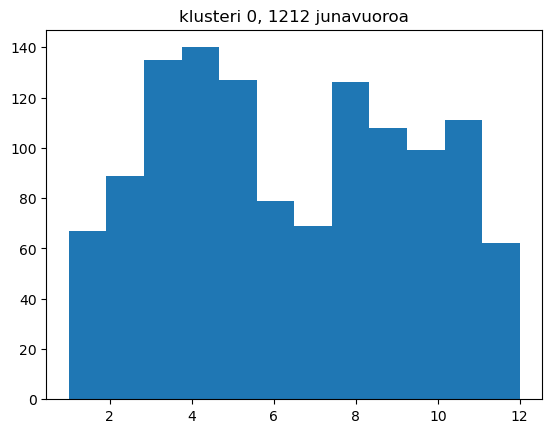

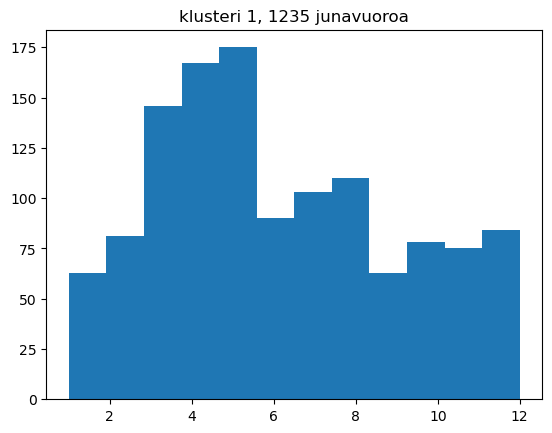

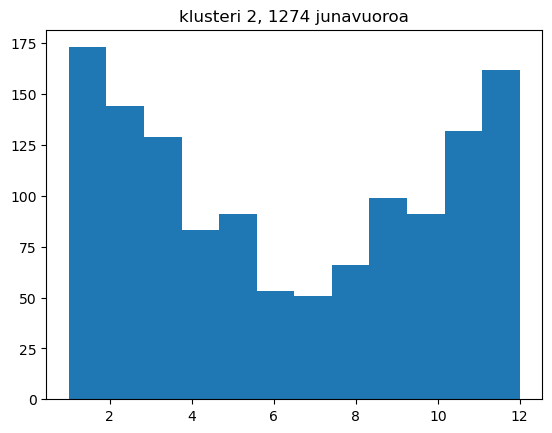

In [36]:
for i in range(kokeilu["cluster_id"].max() + 1):
    kok_df = kokeilu[kokeilu["cluster_id"] == i]
    if len(kok_df) > 0.1 * len(kokeilu):
        plt.hist(kok_df["month"], bins=12)
        plt.title(f"klusteri {i}, {kokeilu['cluster_id'].value_counts().loc[i]} junavuoroa")
        plt.show()

## Testataan klusteroinnin ennustettavuutta

Oppivatko koneoppimismallit kategorisoimaan junavuorot klustereihin?

In [37]:
c_res = clustering_results.loc[:, ["cluster_id", "acceleration"]]
# c_df = clustering_df

Yhdistetään pienemmät klusterit yhteen.

In [38]:
default_lower_bound = max(30, 0.1 * len(train_df))
c_res["cluster_id"] = c_res["cluster_id"].apply(lambda n: fcns.replacement_fcn(n, cluster_df["count"], default_lower_bound))

In [39]:
c_res["cluster_id"].value_counts()

 0    1274
 1    1235
 2    1212
-1     471
Name: cluster_id, dtype: int64

#### k-nearest neighbors

In [40]:
knn = fcns.test_clusters_with_knn(train_df.loc[:, checkpoints], c_res["cluster_id"].to_numpy(), test_size=0.4)

Accuracy: 0.8450536352800954

              precision    recall  f1-score   support

          -1       0.98      0.93      0.95        98
           0       0.80      0.86      0.83       252
           1       0.87      0.81      0.84       242
           2       0.82      0.83      0.82       247

    accuracy                           0.85       839
   macro avg       0.87      0.86      0.86       839
weighted avg       0.85      0.85      0.85       839



#### random forest

In [41]:
rfc = fcns.test_clusters_with_rfc(train_df.loc[:, checkpoints], c_res["cluster_id"].to_numpy(), test_size=0.4)

Accuracy: 0.865315852205006

              precision    recall  f1-score   support

          -1       0.96      0.93      0.95        85
           0       0.85      0.88      0.86       249
           1       0.84      0.91      0.87       254
           2       0.88      0.79      0.83       251

    accuracy                           0.87       839
   macro avg       0.88      0.88      0.88       839
weighted avg       0.87      0.87      0.86       839



In [42]:
importances = [{"checkpoint": checkpoints[i], "importance": importance} for i, importance in enumerate(rfc.feature_importances_)]
importances = pd.DataFrame(importances)
importances.sort_values("importance", ascending=False).head(20)

,checkpoint,importance
37,3700.0,0.021665
38,3800.0,0.018577
36,3600.0,0.015835
34,3400.0,0.015753
39,3900.0,0.015075
368,36800.0,0.014728
35,3500.0,0.014044
367,36700.0,0.013806
366,36600.0,0.011266
185,18500.0,0.010834


## Piirrellään kuvaajia

In [43]:
def bright_spot(i, num):
    if i == num:
        return 0.9
    return 0.3

#### Suurimpien klustereiden keskipisteet

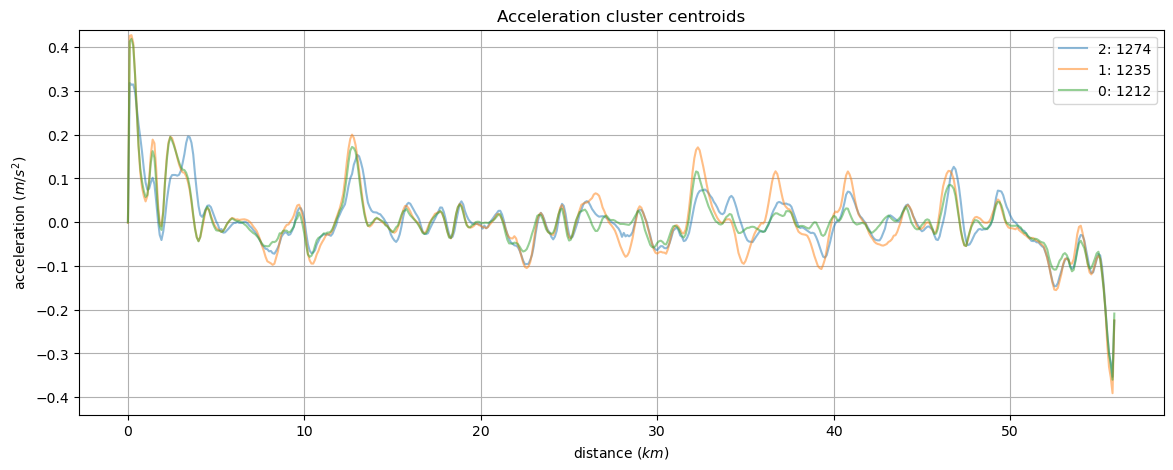

In [44]:
pf.draw_kmeans_centroids(km, checkpoints, train_df["cluster_id"], 3, 0.44)

Samalla voi muistella, että klusterissa 0 on keskimäärin pienempiä kiihtyvyyksiä ja klusterissa 1 keskimäärin suurempia kiihtyvyyksiä kuin klusterissa 2.

In [45]:
cluster_df["mean_mean_abs_accel"].sort_values() * len(checkpoints)

cluster_id
0    35.448548
2    38.754282
1    40.590904
3    47.324437
4    49.288175
Name: mean_mean_abs_accel, dtype: float64

In [46]:
#fig, ax = plt.subplots(figsize=(14, 5))
#ax.plot(checkpoints / 1000, km.cluster_centers_[0, :])

#ax.set_ylabel("acceleration ($m/s^2$)")
#ax.set_xlabel("distance ($km$)")
#ax.set_ylim(-0.5, 0.5)
#ax.grid()
#plt.show()

#### Miten klustereiden keskipisteet eroavat random forestin mielestä tärkeissä kohdissa?

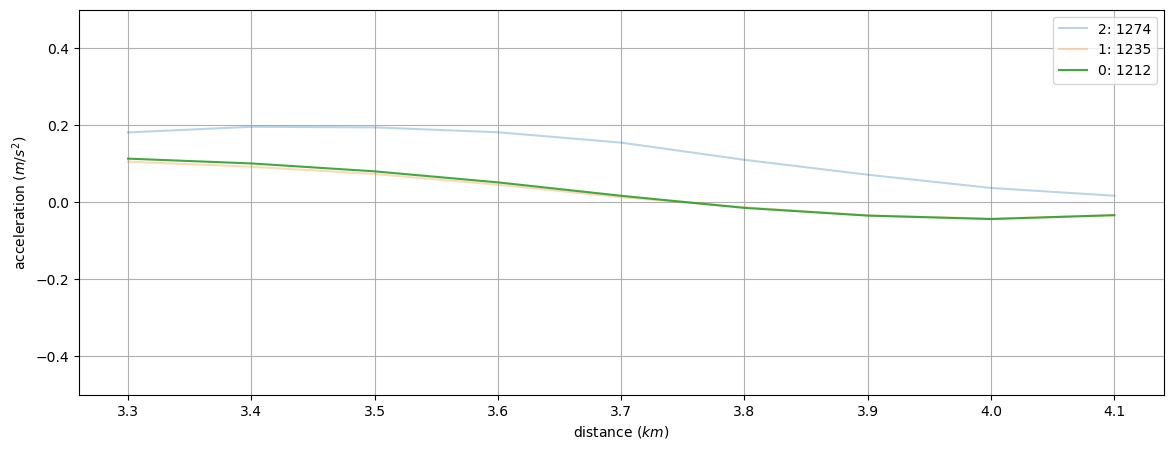

In [47]:
n = 3
start_i = 33
end_i = 42

fig, ax = plt.subplots(figsize=(14, 5))
for i in cluster_df.index[:n]:

    ax.plot(checkpoints[start_i:end_i] / 1000, km.cluster_centers_[i, start_i:end_i], alpha=bright_spot(i, 0), label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

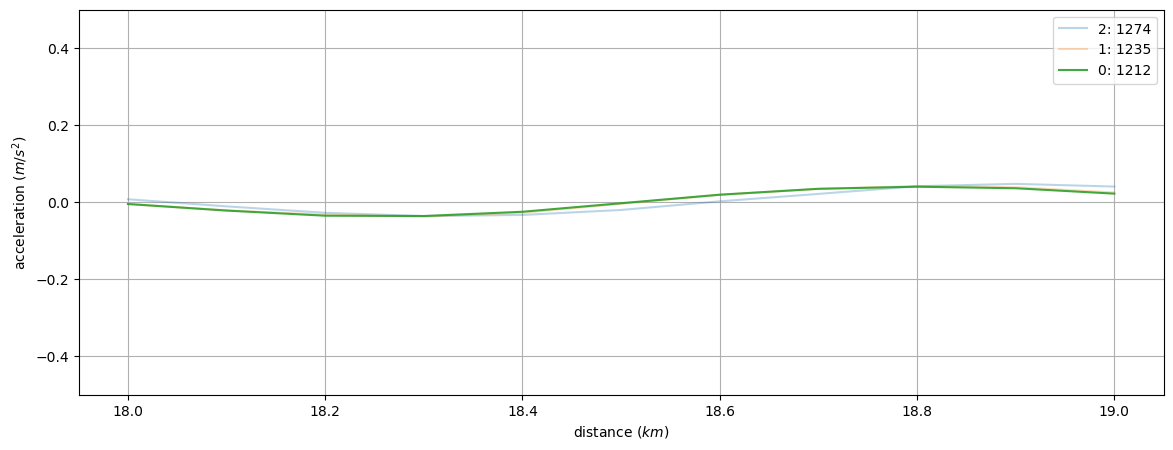

In [48]:
start_i = 180
end_i = 191

fig, ax = plt.subplots(figsize=(14, 5))
for i in cluster_df.index[:n]:

    ax.plot(checkpoints[start_i:end_i] / 1000, km.cluster_centers_[i, start_i:end_i], alpha=bright_spot(i, 0), label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

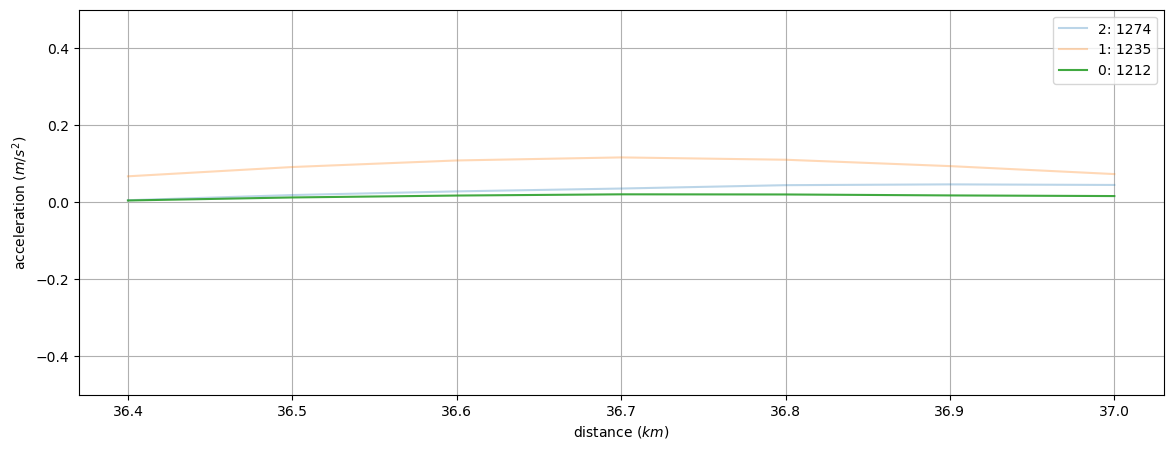

In [49]:
start_i = 364
end_i = 371

fig, ax = plt.subplots(figsize=(14, 5))
for i in cluster_df.index[:n]:

    ax.plot(checkpoints[start_i:end_i] / 1000, km.cluster_centers_[i, start_i:end_i], alpha=bright_spot(i, 0), label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

#### Miltä vähiten kiihdytelleet junat näyttävät?

In [50]:
# kaikki klusterissa 0
train_df.loc[:, ["cluster_id", "abs_sum"]].sort_values("abs_sum").head(15)

,dist_from_speed,cluster_id,abs_sum
departureDate,trainNumber,,
2022-12-05,144,0,10.444444
2020-07-29,140,0,14.170139
2022-09-22,80,0,15.045287
2022-09-17,146,0,15.567302
2022-10-04,80,0,16.085796
2021-08-22,86,0,18.392361
2022-08-27,148,0,18.452877
2021-10-24,86,0,18.828704
2021-03-27,140,0,19.761574


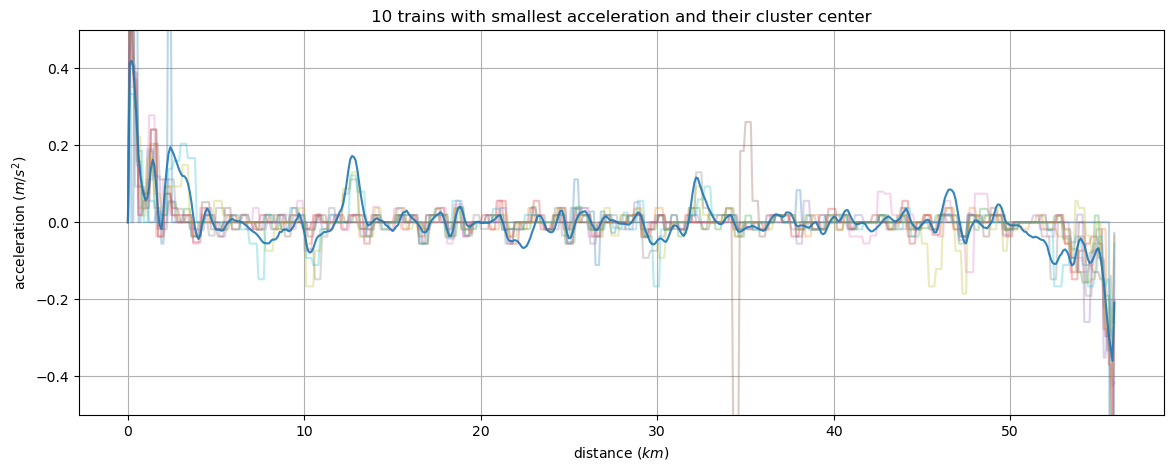

In [51]:
num_of_trains = 10

fig, ax = plt.subplots(figsize=(14, 5))
for date_and_num in train_df.loc[:, ["cluster_id", "abs_sum"]].sort_values("abs_sum").index[:num_of_trains]:
    ax.plot(checkpoints / 1000, train_df.loc[date_and_num, checkpoints], label=date_and_num, alpha=0.3)

ax.plot(checkpoints / 1000, km.cluster_centers_[0, :], alpha=0.9)

ax.set_title(f"{num_of_trains} trains with smallest acceleration and their cluster center")
ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
# ax.legend()
ax.grid()
plt.show()

#### Entäs checkpointit, joissa kiihtyvyyksissä on suurinta hajontaa?

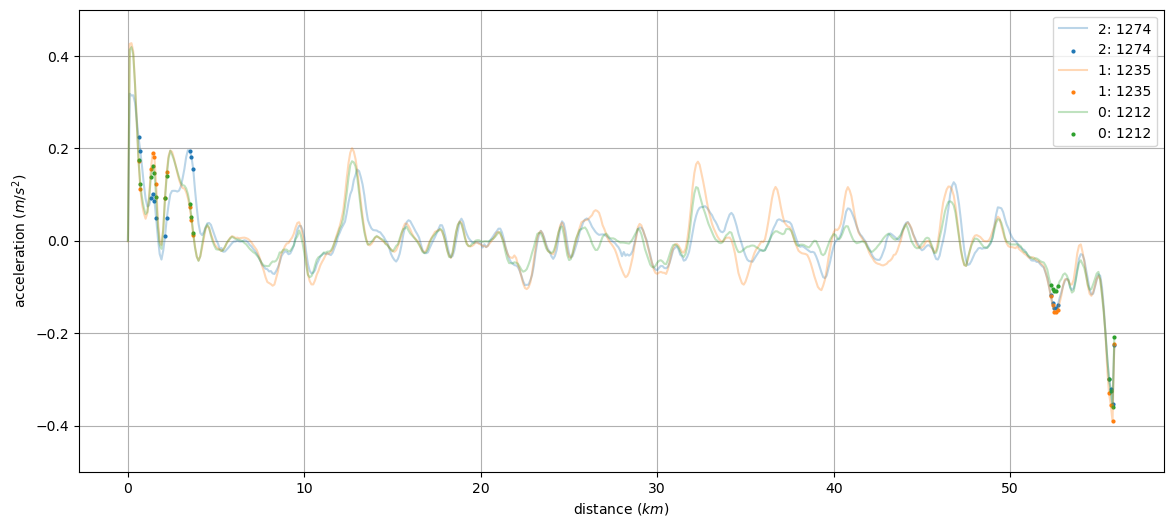

In [52]:
fig, ax = plt.subplots(figsize=(14, 6))
for i in cluster_df.index[:n]:
    ax.plot(checkpoints / 1000, km.cluster_centers_[i, :], alpha=0.3, label=f"{i}: {cluster_df.loc[i, 'count']}")
    ax.scatter(checkpoints[features] / 1000, km.cluster_centers_[i, features], s=4, label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

In [53]:
cluster_df.head()

,count,min_mean_abs_accel,max_mean_abs_accel,mean_mean_abs_accel
cluster_id,,,,
2,1274,0.040200,0.195115,0.069204
1,1235,0.048679,0.191436,0.072484
0,1212,0.018651,0.176800,0.063301
4,271,0.055220,0.176010,0.088015
3,200,0.053016,0.177085,0.084508


In [54]:
for i in range(num_of_clusters):
    print(f"{i}: \t{str(np.round(np.sum(km.cluster_centers_[i, :]), 3)).rjust(7)}")

0: 	 -0.199
1: 	 -0.205
2: 	 -0.193
3: 	 -0.187
4: 	  -0.23
